In [28]:
#%load_ext rpy2.ipython
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import (LogisticRegression, LinearRegression, RidgeClassifier, Lasso, RandomizedLasso)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm,preprocessing
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score,ShuffleSplit,GridSearchCV,train_test_split
from sklearn.metrics import roc_auc_score,roc_curve, auc,confusion_matrix,classification_report,matthews_corrcoef,f1_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier
from sklearn.preprocessing import StandardScaler,Imputer
from sklearn.feature_extraction import DictVectorizer as DV
from tpot import TPOTClassifier
from fancyimpute import  KNN,MICE, SimpleFill, SoftImpute
import warnings
warnings.filterwarnings("ignore")

# Helper functions

In [2]:

def repeatedCV (model, dataFeatures,dataOutcome):
    maxloop = 100
    splitsnb= 10
    testproportion =0.25
    
    results= []
    for k in range(maxloop):
        lecv = ShuffleSplit(n_splits=splitsnb, test_size= testproportion,random_state=1)
        results.append(cross_val_score(model, dataFeatures, dataOutcome, scoring='accuracy', cv=lecv))
    return results

def findOptimalHParametersThoughtCV (model,X,y, param_grid):
    scoringmethod='roc_auc'
    cvnb=10
    
    CV_LR = GridSearchCV(estimator=model,scoring=scoringmethod, param_grid=param_grid, cv= cvnb)
    CV_LR.fit(X, y)
    print('Best parameters from grid search' ,CV_LR.best_params_, ' , best score:', CV_LR.best_score_)
    return CV_LR


def evaluateModel (model,X_testt,y_test):
    risk_threshold=0.5
    
    probs=  model.predict_proba(X_testt)
    y_pred = [int(risk_threshold < p[1]) for p in probs]
    print("Accuracy: %0.2f " % (model.score(X_testt, y_test)),'auc: ',roc_auc_score(y_test, y_pred))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (model.score(X_test, y_test).mean(), model.score(X_test, y_test).std() * 2))
    print('Confusion Matrix\n',confusion_matrix(y_test,y_pred))
    print('Classification report\n',classification_report(y_test,y_pred))
    print('Matthews Correlation coefficient',matthews_corrcoef(y_test,y_pred))
    return y_pred,probs

def plotroc(y_test,pred,probs):
    fpr,tpr, _ = roc_curve(y_test,probs[:,1])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, pred))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def random_date(start, end, position=None):
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    delta = (end - start).total_seconds()
    if position is None:
        offset = np.random.uniform(0., delta)
    else:
        offset = position * delta
    offset = pd.offsets.Second(offset)
    t = start + offset
    #print([t.year,t.month])
    return t

# Loading data

In [11]:
# load dataset and choose 'model'
path_dataset = "mdl_data.csv"
data=pd.read_csv(path_dataset)

choice=1
print('shape before: ',data.shape)
if (choice == 1):   # triage model
    data=data.iloc[:,0:41]   
elif (choice == 2): #after model
    data=data.iloc[:,list(range(0, 11))+list(range(41, 67))]
else: 
    #data = data[['study_id','death', 'evd_ct', 'age', 'temp_triage', 'headache_triage', 'hemorrhage_triage','diarrhea_triage','jaundice_triage','vomiting_triage','abdomnial_triage','asthenia_triage']]
    #data = data[['study_id','death', 'evd_ct', 'disorientation_triage', 'jaundice_triage', 'headache_triage', 'days_admitted']]
    #data = data[['study_id','death', 'evd_ct','referral_time','headache_triage','days_admitted','anuria_triage','quarantine','disorientation_triage','abdomnial_triage','dyspnea_triage','malaria','hiccups_triage','anorexia_triage','hematochezia_triage','gynec_hemorrhage_triage','dehydration_triage']]
    data = data[['study_id','death', 'evd_ct','days_admitted']]



shape before:  (575, 67)


#  Preprocessing and feature engineering


In [12]:
#Preprocessing

################################ Poupulation selection #################
#1-> just location filter, 2-> just entry date, 3-> both
# List of 'filtering' variable possibilites:
#    0  -> No filtering done
#    1  -> Filtering only the location
#    2  -> Filtering only the entrydate
#    3  -> Filtering the location and the entrydate
#    4  -> Filtering between entrydate and enddate
#    5  -> Filtering location between entrydate and enddate

filtering = 0  
locationFilter='Kambia'
# You can specify only year (ex:'2015'), year-month('2015-2'), year-month-day ('2016-2-19') or more (ex:2016-2-19 09:45)
entrydateFilter = '2015-5' 
enddateFilter   = '2016-3'
#######################################################################
# we remove all patients with missing evd_ct. 
#2 possible causes: {1. evd- (No ebola->no death prediction) (417 cases) 2. Unknown (14 cases)} 
data=data[np.isfinite(data['evd_ct'])]  # Dropping from 575 to 144!!
dataheaders = data.dtypes.index

#############    Imputation         ###################################

#data=data.dropna() # Dropping from 144 to 118
#data=data.fillna(round(data.mean())) #Should round to not loose binary format of columns!
#dataimputed = KNN(k=9).complete(data)
#dataimputed = SimpleFill().complete(data)
impmodel = Imputer(missing_values='NaN',strategy="most_frequent",axis=0) #most_frequent
dataimputed= impmodel.fit_transform(data)

data = pd.DataFrame(data=dataimputed,columns=dataheaders)
#data = data.set_index('study_id')
#data = data.reset_index(drop=True) # so we have incremental indexes (dropped samples doesn't count anymore after this)

#######################################################################



ytrue=data[['study_id','death']]
if(choice ==1 or choice==2):
    X=data.drop(['death','evd'],axis=1) #'study_id' could also be added to be droped
else:
    X=data.drop(['death'],axis=1)

#the only columns wirh missing info: ,'malaria','referral_time',evd_ct' (removed higher),'quarantine'(removed by first two)
print('Missing values: \n' ,pd.isnull(X).values.any(), np.where(pd.isnull(X)))


ytrue = ytrue.set_index('study_id')
X = X.set_index('study_id')

print('shape after: ', X.shape)


###################  Adding features for population selection #######################
if (filtering == 1 or filtering == 3 or filtering == 5):
    X['location']= np.random.choice(['Port Loko','Kambia','Western Rural','Western Urban','Guinea'], X.shape[0], p=[0.2,0.2,0.2,0.2,0.2])
    locationdict= pd.DataFrame(X['location']).to_dict(orient = 'records'  ) #In case, it is already included in database(extended version)
    vectorizer = DV( sparse = False )
    vec_tmp = vectorizer.fit_transform( locationdict)
    cities=[k.split('=')[1] for k in vectorizer.get_feature_names()]
    binarycities=pd.DataFrame(vec_tmp, columns=cities)
    binarycities=binarycities.set_index(X.index)
    X = X.join(binarycities)
    X= X[X[locationFilter] == 1]
    del X['location'] # We have to remove it to fit a model
    # Once we have filtered the location, we don't want to keep it for Predictions
    for city in cities:
        del X[city]
    ytrue= ytrue.ix[X.index]
    
if (filtering == 2 or filtering == 3 ):    
    X['entry-date']=pd.Series([random_date('2014-03', '2016-03') for i in range(X.shape[0])])
    X= X.loc[X['entry-date'] > entrydateFilter]
    del X['entry-date']  # Once we have filtered the date, we don't want to keep the date for Predictions
    ytrue= ytrue.ix[X.index]

if (filtering == 4 or filtering == 5):    
    X['entry-date']=pd.Series([random_date('2014-03', '2016-03') for i in range(X.shape[0])])
    X= X.loc[(X['entry-date'] > entrydateFilter) & (X['entry-date'] < enddateFilter)]
    del X['entry-date']  # Once we have filtered the date, we don't want to keep the date for Predictions
    ytrue= ytrue.ix[X.index]
    
ytrue=[int(k) for k in ytrue.as_matrix()]
#####################################################################################
headers = X.dtypes.index

###########################
# Standadizing data lowers score so we don't use it
#scaler = StandardScaler()
#X= scaler.fit_transform(X) #  Scaled data has zero mean and unit variance

# Separating dataset for training and validation. CV will only be done on training set
# Validation set will be only used for testing: real unseen data
# we prefer more training simples with y=1 so we don't use stratify=ytrue because it decreases it
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=2)
print('\n',pd.DataFrame(ytrue).stack().value_counts()) # ytrue: 86 nondeath (60%) and 58 deaths

print(X_test.shape)

Missing values: 
 False (array([], dtype=int64), array([], dtype=int64))
shape after:  (144, 38)

 1    86
0    58
dtype: int64
(22, 38)


# Logistic Regression

Best parameters from grid search {'penalty': 'l2'}  , best score: 0.896896955504
Accuracy: 0.96  auc:  0.858333333333
Confusion Matrix
 [[ 8  2]
 [ 1 11]]
Classification report
              precision    recall  f1-score   support

          0       0.89      0.80      0.84        10
          1       0.85      0.92      0.88        12

avg / total       0.87      0.86      0.86        22

Matthews Correlation coefficient 0.72579654641


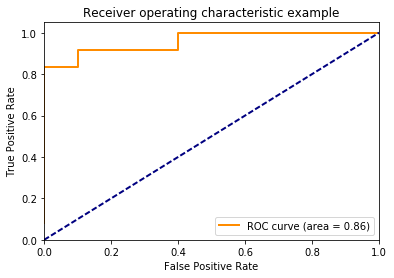

In [25]:
# instantiate a logistic regression model, and fit with training data
# we prefer have false positives than false negatives. So we want high recall for death=1
model = LogisticRegression()

param_grid = { 
    'C': [0.001, 0.01, 0.1,0.3,0.35,0.4,0.45, 0.5, 0.55, 0.6, 0.7, 1, 10],
    'penalty' : ['l1','l2'],
    'max_iter' : [100,500,1000,5000],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'class_weight': [{0:.25, 1:.75}, {0:.5, 1:.5}, {0:.3, 1:.7}, {0:.4, 1:.6},'balanced']
}

optimalModel =findOptimalHParametersThoughtCV(model,X_train,y_train,param_grid)
predictions,probabilities= evaluateModel(optimalModel,X_test,y_test)
plotroc(y_test,predictions,probabilities)


1 0.762082489802
2 0.76130055125
3 0.761253964048
4 0.759207076885


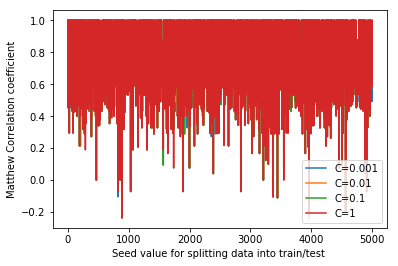

In [146]:
matheus1= list()
matheus2= list()
matheus3= list()
matheus4= list()

for i in range(1,10000):
    X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.1, random_state=i)
    lg1 = LogisticRegression(C=0.02,class_weight='balanced',solver='sag')
    lg1.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs1=  lg1.predict_proba(X_test)
    y_pred1 = [int(0.5 < p[1]) for p in probs1]
    matheus1.append(matthews_corrcoef(y_test,y_pred1))


    lg2 = LogisticRegression(C=0.03,class_weight='balanced',solver='sag')
    lg2.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs2=  lg2.predict_proba(X_test)
    y_pred2 = [int(0.5 < p[1]) for p in probs2]
    matheus2.append(matthews_corrcoef(y_test,y_pred2))

    lg3 = LogisticRegression(C=0.04,class_weight='balanced',solver='sag')
    lg3.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs3=  lg3.predict_proba(X_test)
    y_pred3 = [int(0.5 < p[1]) for p in probs3]
    matheus3.append(matthews_corrcoef(y_test,y_pred3))
    
    lg4 = LogisticRegression(C=0.08,class_weight='balanced',solver='sag')
    lg4.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs4=  lg4.predict_proba(X_test)
    y_pred4 = [int(0.5 < p[1]) for p in probs4]
    matheus4.append(matthews_corrcoef(y_test,y_pred4))

t= list(range(1,10000))


print('1',np.mean(matheus1))
print('2',np.mean(matheus2))
print('3',np.mean(matheus3))
print('4',np.mean(matheus4))



plt.figure()
plt.plot(t,matheus1)
plt.plot(t,matheus2)
plt.plot(t,matheus3)
plt.plot(t,matheus4)


plt.legend(['C=0.001','C=0.01','C=0.1', 'C=1'], loc='lower right')
plt.xlabel('Seed value for splitting data into train/test ')
plt.ylabel('Matthew Correlation coefficient')
plt.show()




mean Classes:  0.851024441413  vs  0.898440110607
Accuracy: 0.82  auc:  0.752380952381
Confusion Matrix
 [[ 4  3]
 [ 1 14]]
Classification report
              precision    recall  f1-score   support

          0       0.80      0.57      0.67         7
          1       0.82      0.93      0.87        15

avg / total       0.82      0.82      0.81        22

Matthews Correlation coefficient 0.561011491466
144


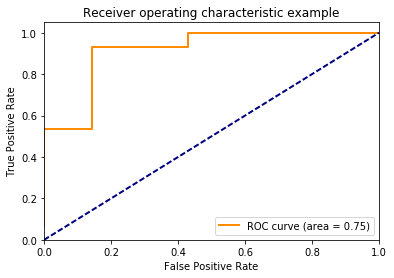

Ridge 4Fold CV Accuracy: 0.83 (+/- 0.15)


In [39]:
res = list()
resclass0 = list()
resclass1 = list()

# Comparing F1 Score by each class  
for i in range(1,10000):
    X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=i)
    lg = LogisticRegression(C=0.04,class_weight='balanced',solver='sag')
    lg.fit(X_train,y_train)
    probs1=  lg.predict_proba(X_test)
    y_pred1 = [int(0.5 < p[1]) for p in probs1]
    [tmp0 ,tmp1]=f1_score(y_test,y_pred1,average=None)
    resclass0.append(tmp0)
    resclass1.append(tmp1)
    res.append(matthews_corrcoef(y_test,y_pred1))
    #print(tmp1,tmp2,end=',')

print('\nmean Classes: ',np.mean(resclass0), ' vs ',np.mean(resclass1) )

X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=7)
lg1 = LogisticRegression(C=0.04,class_weight='balanced',solver='sag')
lg1.fit(X_train,y_train)
#predictions,probabilities= evaluateModel(lg1,X_test,y_test)
predictions,probabilities= evaluateModel(lg1,X_test,y_test)
print(len(ytrue))

plotroc(y_test,predictions,probabilities)

ridge = RidgeClassifier(alpha=0.4)
scores = cross_val_score(ridge, X, ytrue, scoring='accuracy', cv=10)
print("Ridge 4Fold CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

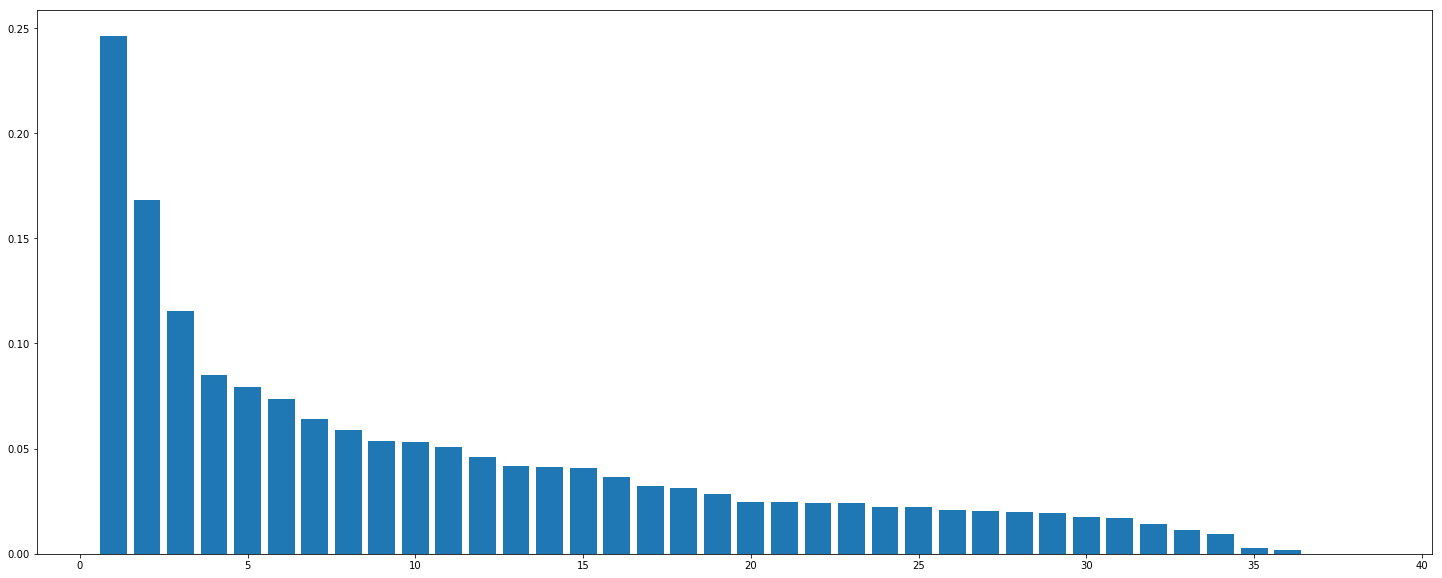

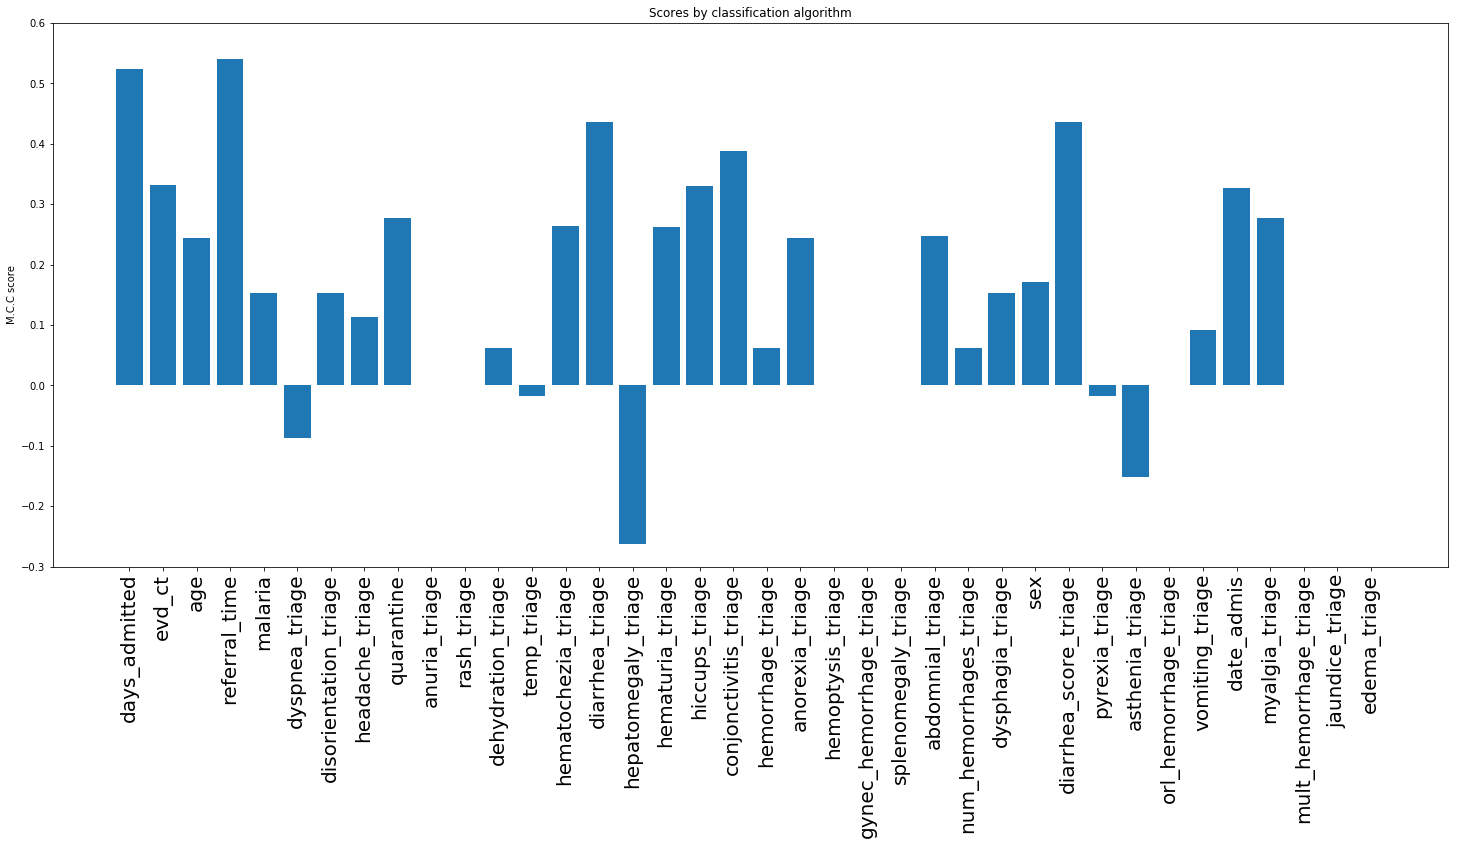

In [242]:
Xscaled= preprocessing.scale(X)
Xscaled= pd.DataFrame(data=Xscaled, columns=headers)
X_train, X_test, y_train, y_test = train_test_split(Xscaled, ytrue, test_size=0.15, random_state=6)
lg1 = LogisticRegression(C=1.004,class_weight='balanced',solver='liblinear',penalty='l1')
ridge= RidgeClassifier(alpha=102,class_weight='balanced')



lg1.fit(X_train,y_train)
ridge.fit(X_train,y_train)
LGCoeff = pd.DataFrame(data=headers,columns=['Features'])

#LGCoeff['LR Coefficient']=np.abs(lg1.coef_.flatten())
LGCoeff['LR Coefficient']=np.abs(ridge.coef_.flatten())


featuresSortedbyLGCoeff = LGCoeff.sort(['LR Coefficient'], ascending=[0])
#print(featuresSortedbyLGCoeff)
#print(X_train[0:5])
#print(np.abs(lg1.coef_))

featureScores= list()
for feature in featuresSortedbyLGCoeff['Features']:
    ridgetmp= RidgeClassifier(alpha=102,class_weight='balanced')
    ridgetmp.fit(X_train[feature].to_frame(),y_train)
    y_predtmp=  ridgetmp.predict(X_test[feature].to_frame())
    featureScores.append(matthews_corrcoef(y_test,y_predtmp))
    #if (feature == 'days_admitted'):
    #    predictions,probabilities= evaluateModel(lgtemp,X_test[feature].to_frame(),y_test)
#print(featureScores)
#print(lgtemp.get_params)
x = list(range(1,39))
fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(x, featuresSortedbyLGCoeff['LR Coefficient'],width=0.8, align='center')
fig, ax = plt.subplots(figsize=(25,10))
rects2 = ax.bar(x, featureScores,width=0.8, align='center')
#fig, ax = plt.subplots(figsize=(25,10))
#rects3 = ax.bar(x, featuresSortedbyLGCoeff['LR Coefficient']*featureScores,width=0.8, align='center')



# add some text for labels, title and axes ticks
ax.set_ylabel('M.C.C score')
ax.set_ylim(-0.3,0.60)
ax.set_title('Scores by classification algorithm')
ax.set_xticks(x)
ax.set_xticklabels((featuresSortedbyLGCoeff['Features']))
plt.setp(ax.get_xticklabels(), fontsize=20, rotation='vertical')
plt.show()


# Ridge

In [160]:
# instantiate a logistic regression model, and fit with training data
# we prefer have false positives than false negatives. So we want high recall for death=1
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=8)


model = RidgeClassifier(class_weight='balanced')

param_grid = { 
    'alpha': [0.1, 0.5, 1, 10, 50,60, 75,85,90,98,100,102,105,115,120 ,200,300,1000]
}

optimalModel =findOptimalHParametersThoughtCV(model,X_train,y_train,param_grid)
print(optimalModel.best_params_,optimalModel.best_index_)




Best parameters from grid search {'alpha': 50}  , best score: 0.939783372365
{'alpha': 50} 4


In [162]:
matheus1= list()
matheus2= list()
matheus3= list()
matheus4= list()

for i in range(1,10000):
    X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.1, random_state=i)
    lg1 = RidgeClassifier(alpha=50,class_weight='balanced')
    lg1.fit(X_train,y_train)
    y_pred1=  lg1.predict(X_test)
    matheus1.append(matthews_corrcoef(y_test,y_pred1))


    lg2 = RidgeClassifier(alpha=20,class_weight='balanced')
    lg2.fit(X_train,y_train)
    y_pred2=  lg2.predict(X_test)
    matheus2.append(matthews_corrcoef(y_test,y_pred2))

    lg3 = RidgeClassifier(alpha=102,class_weight='balanced')
    lg3.fit(X_train,y_train)
    y_pred3=  lg3.predict(X_test)
    matheus3.append(matthews_corrcoef(y_test,y_pred3))
    
    lg4 = RidgeClassifier(alpha=150,class_weight='balanced')
    lg4.fit(X_train,y_train)
    y_pred4=  lg4.predict(X_test)
    matheus4.append(matthews_corrcoef(y_test,y_pred4))


print('1',np.mean(matheus1))
print('2',np.mean(matheus2))
print('3',np.mean(matheus3))
print('4',np.mean(matheus4))

1 0.756184021504
2 0.730604537786
3 0.768283975291
4 0.762813154254


In [8]:
# Final Ridge MODEL
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=2)

ridge= RidgeClassifier(alpha=102,class_weight='balanced')
ridge.fit(X_train,y_train)
y_pred3=  ridge.predict(X_test)
print(matthews_corrcoef(y_test,y_pred3))

1.0


# Decision Tree graph

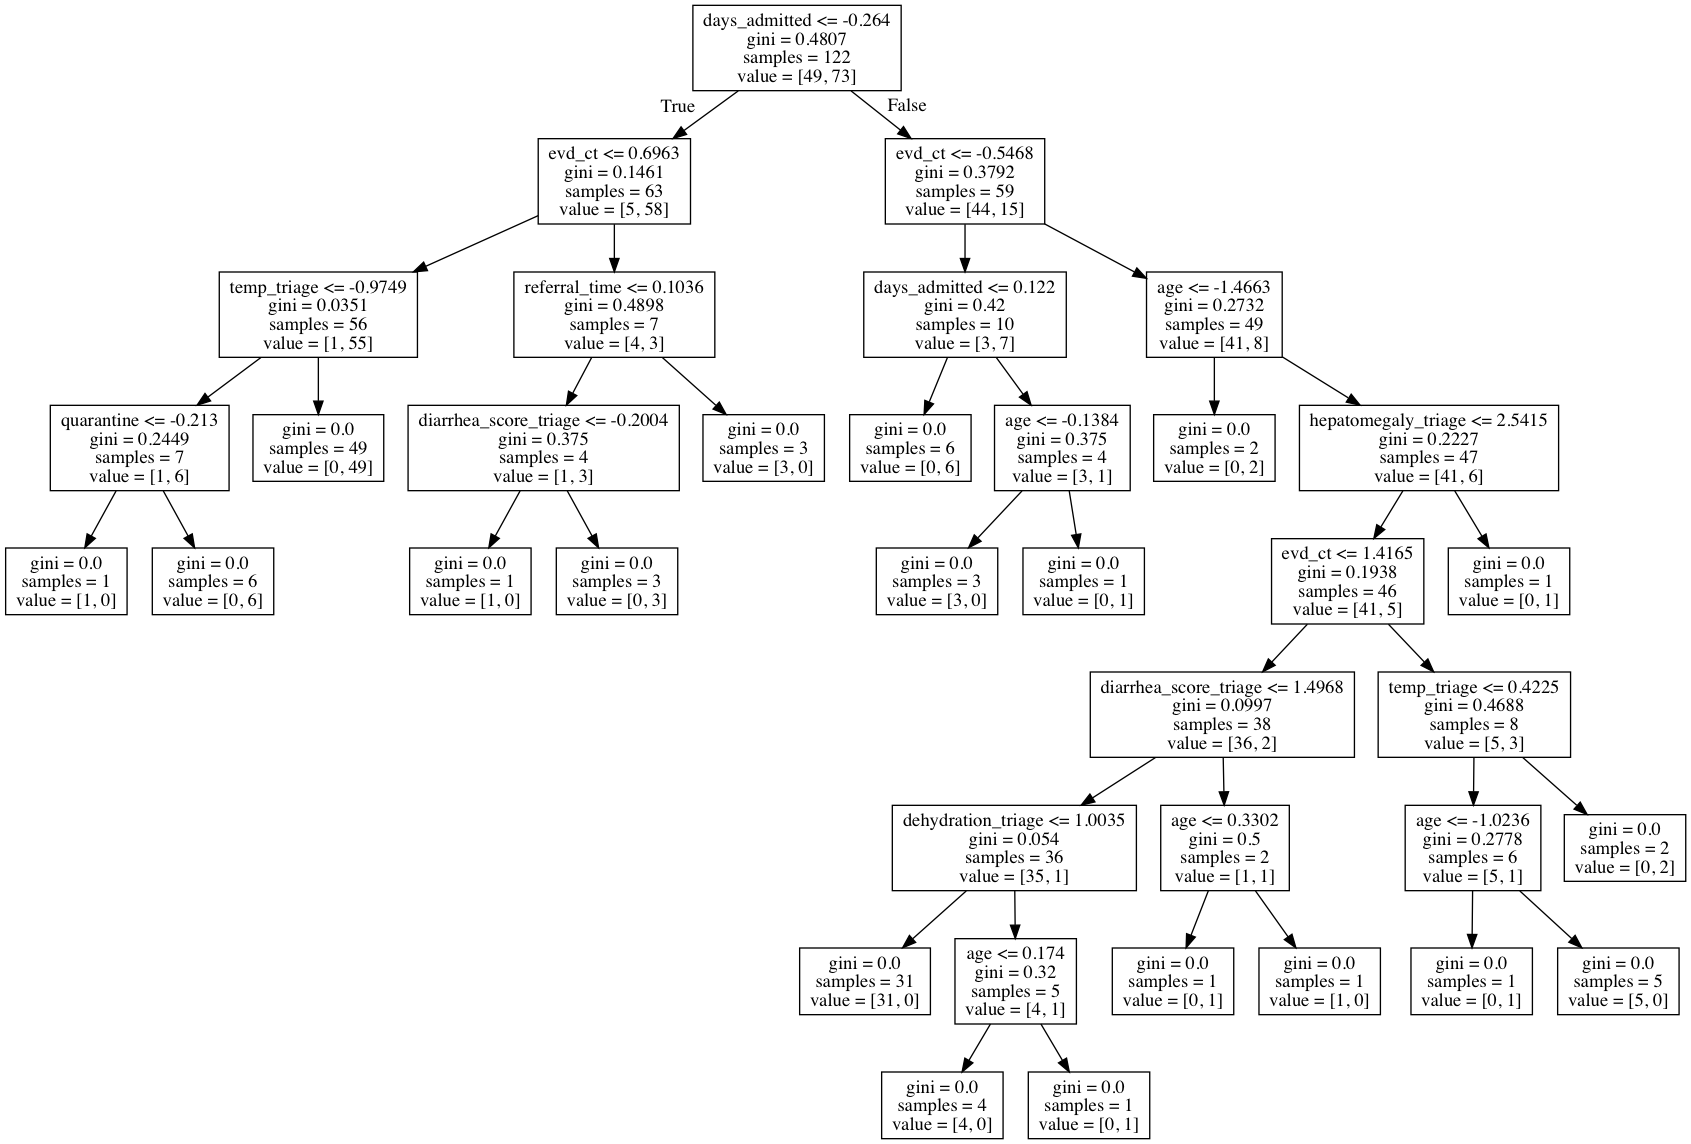

In [214]:
import pydotplus,os
from IPython.display import Image 
from sklearn.tree import DecisionTreeClassifier
clfdt = DecisionTreeClassifier()
clfdt.fit(X_train,y_train)
dot_data = tree.export_graphviz(clfdt,out_file=None, feature_names=headers) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())  

In [215]:
%%R
library(ggplot2)

ggplot(y_pred) 
 # geom_bar(aes(evd_ct), stat = "bin") + 
 # geom_bar(aes(evd_ct, fill = factor(death)), stat = "bin", position = "dodge") +
 # scale_fill_manual(values=c("#DD3333", "#33CC66", "#eeee00"))

ERROR:root:Cell magic `%%R` not found.


# Feature selection through RFE and Randomized Lasso

In [201]:
#rank all features, i.e continue the elimination until the last 3
rfe = RFE(model, 5) #recursive feature elimination, 
rfe = rfe.fit(X, ytrue)
# summarize the selection of the attributes
print(headers[rfe.support_ == True])
#print(rfe.support_)
#print(rfe.ranking_)

print('\nRandomized Lasso \n')
rlasso = RandomizedLasso(alpha=0.0001)
rlasso.fit(X, ytrue)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 headers), reverse=True))



Index(['evd_ct', 'days_admitted', 'referral_time', 'disorientation_triage',
       'hematochezia_triage'],
      dtype='object')

Randomized Lasso 

Features sorted by their score:
[(1.0, 'referral_time'), (1.0, 'headache_triage'), (1.0, 'evd_ct'), (1.0, 'days_admitted'), (1.0, 'age'), (0.995, 'quarantine'), (0.98999999999999999, 'disorientation_triage'), (0.98999999999999999, 'abdomnial_triage'), (0.98499999999999999, 'anuria_triage'), (0.97999999999999998, 'malaria'), (0.96499999999999997, 'hiccups_triage'), (0.95999999999999996, 'dyspnea_triage'), (0.95999999999999996, 'asthenia_triage'), (0.95999999999999996, 'anorexia_triage'), (0.94999999999999996, 'myalgia_triage'), (0.94499999999999995, 'hepatomegaly_triage'), (0.94499999999999995, 'dehydration_triage'), (0.93999999999999995, 'hematochezia_triage'), (0.93500000000000005, 'dysphagia_triage'), (0.93000000000000005, 'conjonctivitis_triage'), (0.92500000000000004, 'pyrexia_triage'), (0.91000000000000003, 'vomiting_triage'), (0.9100

# Feature selection through random forest

Feature ranking:
1. feature 5 days_admitted (0.180045)
2. feature 0 evd_ct (0.115369)
3. feature 3 age (0.074218)
4. feature 6 referral_time (0.038299)
5. feature 7 date_admis (0.036604)
6. feature 21 diarrhea_triage (0.035291)
7. feature 8 temp_triage (0.032870)
8. feature 26 conjonctivitis_triage (0.031760)
9. feature 20 anorexia_triage (0.031454)
10. feature 13 headache_triage (0.031329)
11. feature 17 dysphagia_triage (0.028879)
12. feature 4 quarantine (0.028399)
13. feature 23 vomiting_triage (0.026105)
14. feature 9 pyrexia_triage (0.024337)
15. feature 11 dyspnea_triage (0.024129)
16. feature 22 diarrhea_score_triage (0.023782)
17. feature 19 abdomnial_triage (0.023780)
18. feature 1 malaria (0.023664)
19. feature 2 sex (0.023403)
20. feature 18 asthenia_triage (0.022978)
21. feature 14 hiccups_triage (0.022890)
22. feature 12 disorientation_triage (0.022038)
23. feature 15 myalgia_triage (0.021844)
24. feature 33 dehydration_triage (0.016798)
25. feature 24 hemorrhage_triage (

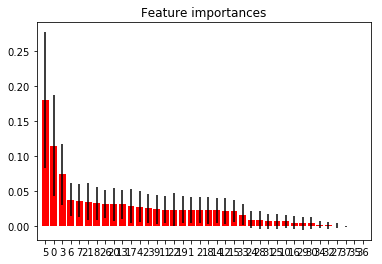

In [202]:
forest = ExtraTreesClassifier(n_estimators=250, #The number of trees in the forest
                              random_state=1)   #max_features: If “auto”, then max_features=sqrt(n_features).

forest.fit(X, ytrue)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], headers[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# SVM

Best parameters from grid search {'kernel': 'rbf'}  , best score: 0.891764246682
Accuracy: 0.97  auc:  0.854166666667
Confusion Matrix
 [[ 5  1]
 [ 2 14]]
Classification report
              precision    recall  f1-score   support

          0       0.71      0.83      0.77         6
          1       0.93      0.88      0.90        16

avg / total       0.87      0.86      0.87        22

Matthew Correlation coefficient 0.677296211956


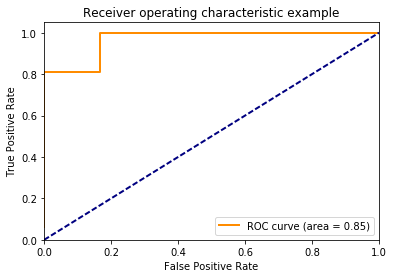

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=12)


svmmodel = svm.SVC(probability=True,class_weight='balanced') #SVM overfits easily with few data and lots of features
param_grid = { 
    'kernel' : ['rbf','linear','poly'],
    'degree' : [1,2,3,5,8] ,
    'C':     [0.1,0.5,1,10],
    'gamma': ['auto', 1/60, 1/90]
}

optimalModel =findOptimalHParametersThoughtCV(svmmodel,X_train,y_train,param_grid)
predictions,probabilities= evaluateModel(optimalModel,X_test,y_test)
plotroc(y_test,predictions,probabilities)

In [ ]:
#from sklearn.calibration import CalibratedClassifierCV
matheus1= list()
matheus2= list()
matheus3= list()
matheus4= list()
t  = np.array([10,5,2,1,0.1,0.01,0.001,0.0001])

for i in range(1,10000):
    X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=i)
    svc1 = svm.SVC(kernel='poly', C=1,degree=1,  gamma=1/90,probability=True)
    svc1.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs1=  svc1.predict_proba(X_test)
    y_pred1 = [int(0.5 < p[1]) for p in probs1]
    matheus1.append(matthews_corrcoef(y_test,y_pred1))


    #linsvc2  = LinearSVC(C=1,class_weight='balanced')
    #svc2=CalibratedClassifierCV(linsvc2) 
    svc2 = svm.SVC(kernel='poly', C=1,degree=1,  gamma=1/90,probability=True,class_weight='balanced')
    svc2.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs2=  svc2.predict_proba(X_test)
    y_pred2 = [int(0.5 < p[1]) for p in probs2]
    matheus2.append(matthews_corrcoef(y_test,y_pred2))

    svc3 = svm.SVC(kernel='poly', C=1,degree=1, gamma=1/90,probability=True,class_weight={0:0.6, 1:0.4})
    svc3.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs3=  svc3.predict_proba(X_test)
    y_pred3 = [int(0.5 < p[1]) for p in probs3]
    matheus3.append(matthews_corrcoef(y_test,y_pred3))


    svc4 = svm.SVC(kernel='poly',degree=1,  C=1, gamma=1/90,probability=True,class_weight={0:0.7, 1:0.3})
    svc4.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs4=  svc4.predict_proba(X_test)
    y_pred4 = [int(0.5 < p[1]) for p in probs4]
    matheus4.append(matthews_corrcoef(y_test,y_pred4),)

t= list(range(1,10000))


print('1',np.mean(matheus1))
print('2',np.mean(matheus2))
print('3',np.mean(matheus3))
print('4',np.mean(matheus4))



plt.figure()
# plt.plot(t,mlp.loss_curve_, )
plt.plot(t,matheus1)
plt.plot(t,matheus2)
plt.plot(t,matheus3)
plt.plot(t,matheus4)


plt.legend(['linear','rbf','poly', 'sigmoid'], loc='lower right')
plt.xlabel('Seed value for splitting data into train/test ')
plt.ylabel('Matthew Correlation coefficient')
plt.show()




In [ ]:
# Final SVM MODEL
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=3)

svc= svm.SVC(kernel='poly',degree=1,  C=1, gamma=1/90,probability=True,class_weight='balanced')
svc.fit(X_train,y_train)
predictions,probabilities= evaluateModel(svc,X_test,y_test)
plotroc(y_test,predictions,probabilities)


# KNN

Best parameters from grid search {'n_neighbors': 8}  , best score: 0.810172716628
Accuracy: 0.97  auc:  0.944444444444
Confusion Matrix
 [[ 8  1]
 [ 0 13]]
Classification report
              precision    recall  f1-score   support

          0       1.00      0.89      0.94         9
          1       0.93      1.00      0.96        13

avg / total       0.96      0.95      0.95        22

Matthew Correlation coefficient 0.908513525159


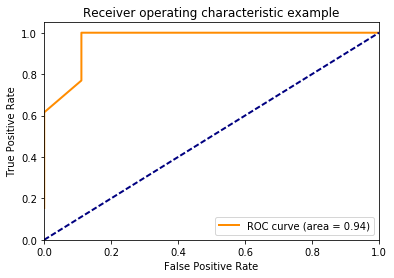

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=52)

nbofneighbourslist= list(range(1,100))
neigh = KNeighborsClassifier()
param_grid = { 
    'n_neighbors' : [8],
    'weights' : ['uniform','distance'] ,
    'metric':     ['minkowski','manhattan','chebyshev'],
}

optimalModel =findOptimalHParametersThoughtCV(neigh,X_train,y_train,param_grid)
predictions,probabilities= evaluateModel(optimalModel,X_test,y_test)
plotroc(y_test,predictions,probabilities)



In [ ]:
matheus1= list()
matheus2= list()
matheus3= list()
matheus4= list()



for i in range(1,10000):
    X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=i)
    knn1 = KNeighborsClassifier(n_neighbors=8,weights='uniform',metric='minkowski')
    knn1.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs1=  knn1.predict_proba(X_test)
    y_pred1 = [int(0.5 < p[1]) for p in probs1]
    matheus1.append(matthews_corrcoef(y_test,y_pred1))
 
    knn2 = KNeighborsClassifier(n_neighbors=8,weights='uniform',metric='manhattan')
    knn2.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs2=  knn2.predict_proba(X_test)
    y_pred2 = [int(0.5 < p[1]) for p in probs2]
    matheus2.append(matthews_corrcoef(y_test,y_pred2))

    knn3 = KNeighborsClassifier(n_neighbors=8,weights='uniform',metric='chebyshev')
    knn3.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs3=  knn3.predict_proba(X_test)
    y_pred3 = [int(0.5 < p[1]) for p in probs3]
    matheus3.append(matthews_corrcoef(y_test,y_pred3))

print('1',np.mean(matheus1))
print('2',np.mean(matheus2))
print('3',np.mean(matheus3))


In [ ]:
# Final KNN MODEL
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=1)

neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(X_train,y_train)
predictions,probabilities= evaluateModel(neigh,X_test,y_test)
plotroc(y_test,predictions,probabilities)

#  Random Forest

In [8]:
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(random_state=1,class_weight='balanced')

# Train the classifier to take the training features and learn how they relate
# to the training y (the species)
print('\n Random Forest Classifier: \n')

param_grid = { 
    'n_estimators': [1 ,10 ,50 ,100 ,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth'   : [1 ,10 ,15 ,20 ,25],
   # 'class_weight': [{0:.25, 1:.75}, {0:.5, 1:.5}, {0:.3, 1:.7}, {0:.4, 1:.6} ,'balanced'  ]
}

optimalModel =findOptimalHParametersThoughtCV(clf,X_train,y_train,param_grid)
predictions,probabilities= evaluateModel(optimalModel,X_test,y_test)
#plotroc(y_test,predictions,probabilities)


 Random Forest Classifier: 

Best parameters from grid search {'max_features': 'log2'}  , best score: 0.879054449649
Accuracy: 0.95  auc:  0.944444444444
Confusion Matrix
 [[ 8  1]
 [ 0 13]]
Classification report
              precision    recall  f1-score   support

          0       1.00      0.89      0.94         9
          1       0.93      1.00      0.96        13

avg / total       0.96      0.95      0.95        22

Matthew Correlation coefficient 0.908513525159


In [ ]:
matheus1= list()
matheus2= list()
matheus3= list()
matheus4= list()
matheus5= list()

m1= list()
m2= list()
m3= list()
m4= list()
m5= list()

for j in range(1,10000):
    X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=j)
    for i in range(5,30):
        #X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=i)
    
        rf1= RandomForestClassifier(max_depth=None,n_estimators=40, max_features=25,class_weight='balanced',random_state=i)
        rf1.fit(X_train,y_train)
        #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
        probs1=  rf1.predict_proba(X_test)
        y_pred1 = [int(0.5 < p[1]) for p in probs1]
        matheus1.append(matthews_corrcoef(y_test,y_pred1))
 
        rf2= RandomForestClassifier(n_estimators=70, max_features=25,class_weight='balanced',random_state=i)
        rf2.fit(X_train,y_train)
        #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
        probs2=  rf2.predict_proba(X_test)
        y_pred2 = [int(0.5 < p[1]) for p in probs2]
        matheus2.append(matthews_corrcoef(y_test,y_pred2))

        rf3= RandomForestClassifier(n_estimators=100, max_features=25,class_weight='balanced',random_state=i)
        rf3.fit(X_train,y_train)
        #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
        probs3=  rf3.predict_proba(X_test)
        y_pred3 = [int(0.5 < p[1]) for p in probs3]
        matheus3.append(matthews_corrcoef(y_test,y_pred3))

        rf4= RandomForestClassifier(n_estimators=180, max_features=25,class_weight='balanced',random_state=i)
        rf4.fit(X_train,y_train)
        #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
        probs4=  rf4.predict_proba(X_test)
        y_pred4 = [int(0.5 < p[1]) for p in probs4]
        matheus4.append(matthews_corrcoef(y_test,y_pred4))

        rf5= RandomForestClassifier(n_estimators=250, max_features=25,class_weight='balanced',random_state=i)
        rf5.fit(X_train,y_train)
        #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
        probs5=  rf5.predict_proba(X_test)
        y_pred5 = [int(0.5 < p[1]) for p in probs5]
        matheus5.append(matthews_corrcoef(y_test,y_pred5))

    m1.append(np.mean(matheus1))
    m2.append(np.mean(matheus2))
    m3.append(np.mean(matheus3))
    m4.append(np.mean(matheus4))
    m5.append(np.mean(matheus5))

print(j,'20T',np.mean(m1))
print(j,'50T',np.mean(m2))
print(j,'101T',np.mean(m3))
print(j,'150T',np.mean(m4))
print(j,'250T',np.mean(m5),'\n\n')

results= [np.mean(m1),np.mean(m2),np.mean(m3),np.mean(m4),np.mean(m5)]
t=[20,50,100,150,250]
plt.figure()
plt.scatter(t,results)
plt.xlabel('The number of trees in the forest')
plt.ylabel('Matthew Correlation coefficient')
plt.show()

In [ ]:
print(X_train.shape)

In [ ]:
# Final Random Forest MODEL
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=1)

rf = RandomForestClassifier(n_estimators=100, max_features=int(X.shape[1]*0.66),class_weight='balanced',random_state=1)
rf.fit(X_train,y_train)
predictions,probabilities= evaluateModel(rf,X_test,y_test)
plotroc(y_test,predictions,probabilities)

#  Neural Nets

In [ ]:

# Fit only to the training data then apply the transformations to the data:
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)
#print(X_train)


hls = list()
for i in range(1,41):
    hls.append(i)
    hls.append([i,i])
    hls.append([i,i,i])

param_grid = { 
    'random_state' : [1],
    'alpha' : [0.001, 0.01,0.1, 1],
    'activation': ['tanh', 'logistic', 'identity','relu'],
    'hidden_layer_sizes': hls
}
optimalModel =findOptimalHParametersThoughtCV(MLPClassifier(),X_train,y_train,param_grid)
predictions,probabilities= evaluateModel(optimalModel,X_test,y_test)
plotroc(y_test,predictions,probabilities)


In [ ]:

matheus1= list()
matheus2= list()
matheus3= list()
matheus4= list()
for i in range(1,10000): #, random_state=10
    mlp = MLPClassifier(hidden_layer_sizes=(i),alpha=0.001,activation='tanh', random_state=100)
    mlp.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs=  mlp.predict_proba(X_test)
    y_pred = [int(0.5 < p[1]) for p in probs]
    matheus1.append(matthews_corrcoef(y_test,y_pred))

for i in range(1,40): #, random_state=10
    mlp = MLPClassifier(hidden_layer_sizes=(i),alpha=0.01,activation='tanh', random_state=100)
    mlp.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs=  mlp.predict_proba(X_test)
    y_pred = [int(0.5 < p[1]) for p in probs]
    matheus2.append(matthews_corrcoef(y_test,y_pred))

for i in range(1,40): #, random_state=10
    mlp = MLPClassifier(hidden_layer_sizes=(i),alpha=0.1,activation='tanh', random_state=100)
    mlp.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs=  mlp.predict_proba(X_test)
    y_pred = [int(0.5 < p[1]) for p in probs]
    matheus3.append(matthews_corrcoef(y_test,y_pred))
    
for i in range(1,40): #, random_state=10
    mlp = MLPClassifier(hidden_layer_sizes=(i),alpha=1,activation='tanh', random_state=100)
    mlp.fit(X_train,y_train)
    #predictions,probabilities= evaluateModel(mlp,X_test,y_test)
    probs=  mlp.predict_proba(X_test)
    y_pred = [int(0.5 < p[1]) for p in probs]
    matheus4.append(matthews_corrcoef(y_test,y_pred))
    
print('1',np.mean(matheus1))
print('2',np.mean(matheus2))
print('3',np.mean(matheus3))
print('4',np.mean(matheus4))

plt.figure()
t= np.arange(1, 40, 1)
# plt.plot(t,mlp.loss_curve_, )
plt.plot(t,matheus1)
plt.plot(t,matheus2)
plt.plot(t,matheus3)
plt.plot(t,matheus4)
plt.legend(['0.001', '0.01','0.1','1'], loc='upper left')
plt.xlabel('Number of nodes in the single hidden layer')
plt.ylabel('Matthew Correlation coefficient')
plt.show()



In [ ]:
# Final NN MODEL 
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=1)


mlp = MLPClassifier(hidden_layer_sizes=(26),alpha=0.1,activation='tanh',random_state=45)
mlp.fit(X_train,y_train)
predictions,probabilities= evaluateModel(mlp,X_test,y_test)
plotroc(y_test,predictions,probabilities)

# Final Model comparaison

In [5]:
pro1= list()
pro2= list()
pro3= list()
pro4= list()

matheus1= list()
matheus1b= list()
matheus2= list()
matheus3= list()
matheus4= list()
matheus5= list()
matheus6= list()
matheus7= list()
matheus8= list()
matheus9= list()
matheus10= list()
matheus11= list()
matheusEns = list()


time1= list()
time1b= list()
time2= list()
time3= list()
time4= list()
time5= list()

for i in range(1,10):
    #train, validate, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))]) 80% train set, 10% test and 10% validation
    X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.15, random_state=i)
    #LR
    start_time = time.time()
    lg = LogisticRegression(C=0.02,class_weight='balanced',solver='sag')
    #lg = LogisticRegression()
    lg.fit(X_train,y_train)
    probs1=  lg.predict_proba(X_test)
    p1_list=  [p[1] for p in probs1]
    y_pred1 = [int(0.5 < p[1]) for p in probs1]
    matheus1.append(matthews_corrcoef(y_test,y_pred1))
    time1.append(time.time() - start_time)
    
    # Ridge
    start_time = time.time()
    ridge= RidgeClassifier(alpha=102,class_weight='balanced')
    ridge.fit(X_train,y_train)
    y_pred1b=  ridge.predict(X_test)
    matheus1b.append(matthews_corrcoef(y_test,y_pred1b))
    time1b.append(time.time() - start_time)
    
    # KNN
    start_time = time.time()
    knn= KNeighborsClassifier(n_neighbors=8)
    #knn= KNeighborsClassifier()
    knn.fit(X_train,y_train)
    probs2=  knn.predict_proba(X_test)
    p2_list=  [p[1] for p in probs2]
    y_pred2 = [int(0.5 < p[1]) for p in probs2]
    matheus2.append(matthews_corrcoef(y_test,y_pred2))
    time2.append(time.time() - start_time)
    
    # SVM
    start_time = time.time()
    svc= svm.SVC(kernel='poly',degree=1,  C=1, gamma=1/90,probability=True,class_weight='balanced')
    #svc= svm.SVC(probability=True)
    svc.fit(X_train,y_train)
    probs3=  svc.predict_proba(X_test)
    p3_list=  [p[1] for p in probs3]
    y_pred3 = [int(0.5 < p[1]) for p in probs3]
    matheus3.append(matthews_corrcoef(y_test,y_pred3))
    time3.append(time.time() - start_time)
    
    # RANDOM FOREST
    start_time = time.time()
    rf= RandomForestClassifier(n_estimators=100, max_features=int(X.shape[1]*0.66),class_weight='balanced',random_state=i)
    #rf= RandomForestClassifier()
    rf.fit(X_train,y_train)
    probs4=  rf.predict_proba(X_test)
    p4_list=  [p[1] for p in probs4]
    y_pred4 = [int(0.5 < p[1]) for p in probs4]
    matheus4.append(matthews_corrcoef(y_test,y_pred4))
    time4.append(time.time() - start_time)
    
    #NN
    start_time = time.time()
    mlp = MLPClassifier(hidden_layer_sizes=(26),alpha=0.1,activation='tanh',random_state=i)
    #mlp = MLPClassifier()
    mlp.fit(X_train,y_train)
    probs5=  mlp.predict_proba(X_test)
    p5_list=  [p[1] for p in probs5]
    y_pred5 = [int(0.5 < p[1]) for p in probs5]
    matheus5.append(matthews_corrcoef(y_test,y_pred5))
    time5.append(time.time() - start_time)
    
    ############Probabilities
    
    combined1average= np.mean([p1_list,p2_list,p3_list,p4_list,p5_list],axis=0)
    pro1.append(matthews_corrcoef(y_test,[int(0.5 < p) for p in combined1average]))
    
    combined2average= np.mean([p1_list,p1_list,p2_list,p5_list,p5_list],axis=0)
    pro2.append(matthews_corrcoef(y_test,[int(0.5 < p) for p in combined2average]))
    
    combined3average= np.mean([p1_list,p1_list,p2_list,p3_list,p4_list,p5_list,p5_list],axis=0)
    pro3.append(matthews_corrcoef(y_test,[int(0.5 < p) for p in combined3average]))
    
    combined4average= np.mean([p1_list,p1_list,p1_list,p2_list,p3_list,p5_list,p5_list],axis=0)
    pro4.append(matthews_corrcoef(y_test,[int(0.5 < p) for p in combined4average]))
    
    
    ############Combined
    combined1 = pd.concat([pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred2,columns=['KNN']),pd.DataFrame(data=y_pred3,columns=['SVM']),pd.DataFrame(data=y_pred4,columns=['RF']),pd.DataFrame(data=y_pred5,columns=['NN'])], axis=1)
    #combined = pd.concat([pd.DataFrame(data=y_pred1,columns=['LG']),pd.DataFrame(data=y_pred3,columns=['KNN']),pd.DataFrame(data=y_pred4,columns=['NN'])], axis=1)
    finalCombinedModel1=((combined1 == 0).sum(axis=1)< 3).astype(int) 
    matheus6.append(matthews_corrcoef(y_test,finalCombinedModel1))
    
    combined2 = pd.concat([pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred2,columns=['KNN']),pd.DataFrame(data=y_pred5,columns=['NN']),pd.DataFrame(data=y_pred5,columns=['NN'])], axis=1)
    #combined = pd.concat([pd.DataFrame(data=y_pred1,columns=['LG']),pd.DataFrame(data=y_pred3,columns=['KNN']),pd.DataFrame(data=y_pred4,columns=['NN'])], axis=1)
    finalCombinedModel2=((combined2 == 0).sum(axis=1)< 3).astype(int) 
    matheus7.append(matthews_corrcoef(y_test,finalCombinedModel2))
    
    combined3 = pd.concat([pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred1,columns=['LG']),pd.DataFrame(data=y_pred2,columns=['KNN']),pd.DataFrame(data=y_pred3,columns=['SVM']),pd.DataFrame(data=y_pred4,columns=['RF']),pd.DataFrame(data=y_pred5,columns=['NN']),pd.DataFrame(data=y_pred5,columns=['NN'])], axis=1)
    #combined = pd.concat([pd.DataFrame(data=y_pred1,columns=['LG']),pd.DataFrame(data=y_pred3,columns=['KNN']),pd.DataFrame(data=y_pred4,columns=['NN'])], axis=1)
    finalCombinedModel3=((combined3 == 0).sum(axis=1)< 4).astype(int) 
    matheus8.append(matthews_corrcoef(y_test,finalCombinedModel3))
    
    combined4 = pd.concat([pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred2,columns=['KNN']),pd.DataFrame(data=y_pred3,columns=['SVM']),pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred5,columns=['NN']),pd.DataFrame(data=y_pred5,columns=['NN'])], axis=1)
    #combined = pd.concat([pd.DataFrame(data=y_pred1,columns=['LG']),pd.DataFrame(data=y_pred3,columns=['KNN']),pd.DataFrame(data=y_pred4,columns=['NN'])], axis=1)
    finalCombinedModel4=((combined4 == 0).sum(axis=1)< 4).astype(int) 
    matheus9.append(matthews_corrcoef(y_test,finalCombinedModel4))
    
    ensemble = VotingClassifier(estimators=[('LR',ridge), ('knn',knn), ('nn',mlp)], weights=[2,1,2],voting='hard')
    ensemble.fit(X_train,y_train)
    y_predEns=  ensemble.predict(X_test)
    matheusEns.append(matthews_corrcoef(y_test,y_predEns))
    #########Boosted
    Xboosted1 = pd.concat([pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred2,columns=['KNN']),pd.DataFrame(data=y_pred3,columns=['SVM']),pd.DataFrame(data=y_pred4,columns=['RF']),pd.DataFrame(data=y_pred5,columns=['NN'])], axis=1)
    #X_Boostedtrain, X_Boostedtest, y_Boostedtrain, y_Boostedtest = train_test_split(Xboosted, y_test, test_size=0.15, random_state=3)
    lg10 = LogisticRegression(C=0.04,class_weight='balanced',solver='sag')
    lg10.fit(Xboosted1,y_test)
    probs10=  lg10.predict_proba(Xboosted1)
    y_pred10 = [int(0.5 < p[1]) for p in probs10]
    matheus10.append(matthews_corrcoef(y_test,y_pred10))

    Xboosted2 = pd.concat([pd.DataFrame(data=y_pred1b,columns=['LG']),pd.DataFrame(data=y_pred2,columns=['KNN']),pd.DataFrame(data=y_pred3,columns=['SVM']),pd.DataFrame(data=y_pred4,columns=['RF']),pd.DataFrame(data=y_pred5,columns=['NN'])], axis=1)
    #X_Boostedtrain, X_Boostedtest, y_Boostedtrain, y_Boostedtest = train_test_split(Xboosted, y_test, test_size=0.15, random_state=3)
    lg11 = LogisticRegression(C=0.04,class_weight='balanced',solver='sag')
    lg11.fit(Xboosted2,y_test)
    probs11=  lg10.predict_proba(Xboosted2)
    y_pred11 = [int(0.5 < p[1]) for p in probs11]
    matheus11.append(matthews_corrcoef(y_test,y_pred11))
    
    

print("LR  : %0.3f (+/- %0.2f) , Average running time: %0.3f " % (np.mean(matheus1),np.var(matheus1),np.mean(time1)))
print("Ridge  : %0.3f (+/- %0.2f) , Average running time: %0.3f " % (np.mean(matheus1b),np.var(matheus1b),np.mean(time1b)))

print("KNN : %0.3f (+/- %0.2f) , Average running time: %0.3f " % (np.mean(matheus2),np.var(matheus2),np.mean(time2)))
print("SVM : %0.3f (+/- %0.2f) , Average running time: %0.3f " % (np.mean(matheus3),np.var(matheus3),np.mean(time3)))
print("RF  : %0.3f (+/- %0.2f) , Average running time: %0.3f " % (np.mean(matheus4),np.var(matheus4),np.mean(time4)))
print("NN  : %0.3f (+/- %0.2f) , Average running time: %0.3f " % (np.mean(matheus5),np.var(matheus5),np.mean(time5)))

print("\nPRO0  : %0.3f (+/- %0.2f)" % (np.mean(pro1),np.var(pro1)))
print("PRO0  : %0.3f (+/- %0.2f)" % (np.mean(pro2),np.var(pro2)))
print("PRO0  : %0.3f (+/- %0.2f)" % (np.mean(pro3),np.var(pro3)))
print("PRO0  : %0.3f (+/- %0.2f)" % (np.mean(pro4),np.var(pro4)))


print("\nAll1  : %0.3f (+/- %0.2f)" % (np.mean(matheus6),np.var(matheus6)))
print("All2  : %0.3f (+/- %0.2f)" % (np.mean(matheus7),np.var(matheus7)))
print("All3  : %0.3f (+/- %0.2f)" % (np.mean(matheus8),np.var(matheus8)))
print("All4  : %0.3f (+/- %0.2f)" % (np.mean(matheus9),np.var(matheus9)))
print("Scikit voting  : %0.3f (+/- %0.2f)" % (np.mean(matheusEns),np.var(matheusEns)))


print("\nBoosted1  : %0.3f (+/- %0.2f)" % (np.mean(matheus10),np.var(matheus10)))
print("\nBoosted2 : %0.3f (+/- %0.2f)" % (np.mean(matheus11),np.var(matheus11)))

LR  : 0.817 (+/- 0.02) , Average running time: 0.008 
Ridge  : 0.817 (+/- 0.02) , Average running time: 0.004 
KNN : 0.788 (+/- 0.02) , Average running time: 0.002 
SVM : 0.807 (+/- 0.01) , Average running time: 0.005 
RF  : 0.714 (+/- 0.01) , Average running time: 0.154 
NN  : 0.792 (+/- 0.01) , Average running time: 0.103 

PRO0  : 0.874 (+/- 0.01)
PRO0  : 0.856 (+/- 0.01)
PRO0  : 0.856 (+/- 0.01)
PRO0  : 0.874 (+/- 0.01)

All1  : 0.807 (+/- 0.01)
All2  : 0.853 (+/- 0.01)
All3  : 0.807 (+/- 0.01)
All4  : 0.829 (+/- 0.01)
Scikit voting  : 0.853 (+/- 0.01)

Boosted1  : 0.817 (+/- 0.01)

Boosted2 : 0.817 (+/- 0.01)


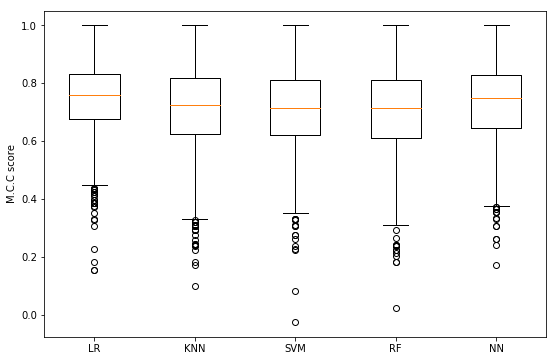

In [19]:
import plotly.plotly as py
import plotly.graph_objs as go

scores = [matheus1b, matheus2, matheus3, matheus4, matheus5]
times  = [time1, time2, time3, time4, time5]
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(scores)
ax.set_xticklabels(['LR', 'KNN', 'SVM', 'RF','NN'])
ax.set_ylabel('M.C.C score')
plt.show()

# Save the figure
fig.savefig('fig4scores.png', bbox_inches='tight')

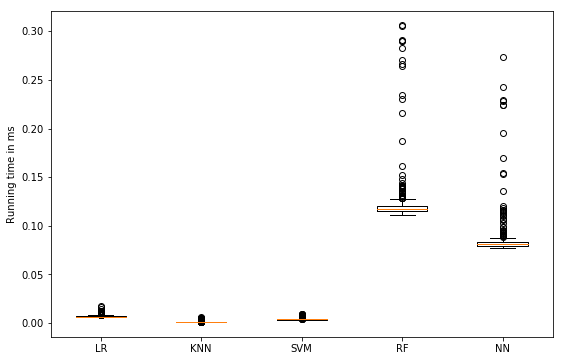

In [17]:

times  = [time1, time2, time3, time4, time5]
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(times)
ax.set_xticklabels(['LR', 'KNN', 'SVM', 'RF','NN'])
ax.set_ylabel('Running time in ms')
plt.show()

# Save the figure
fig.savefig('fig3times.png', bbox_inches='tight')

# Bar plots

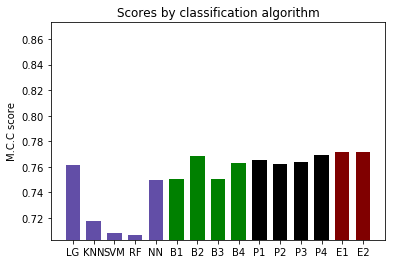

In [178]:
scores  = [np.mean(matheus1b),np.mean(matheus2),np.mean(matheus3),np.mean(matheus4), np.mean(matheus5), np.mean(matheus6), np.mean(matheus7),np.mean(matheus8),np.mean(matheus9),np.mean(pro1),np.mean(pro2),np.mean(pro3),np.mean(pro4),np.mean(matheus10),np.mean(matheus11)]

x = list(range(1,16))

fig, ax = plt.subplots()
colors = ['#624ea7','#624ea7','#624ea7','#624ea7','#624ea7', 'g','g','g','g','k', 'k','k', 'k','maroon', 'maroon']


rects1 = ax.bar(x, scores,width=0.7, align='center',color=colors)

# add some text for labels, title and axes ticks
ax.set_ylabel('M.C.C score')
ax.set_ylim(0.703,0.873)
ax.set_title('Scores by classification algorithm')
ax.set_xticks(x)
ax.set_xticklabels(('LG', 'KNN', 'SVM', 'RF', 'NN', 'B1','B2','B3','B4','P1','P2','P3','P4','E1','E2'))

plt.show()

# Boosting Model

In [ ]:
Xboosted = pd.concat([pd.DataFrame(data=y_pred1,columns=['LG']),pd.DataFrame(data=y_pred2,columns=['KNN']),pd.DataFrame(data=y_pred3,columns=['SVM']),pd.DataFrame(data=y_pred4,columns=['RF']),pd.DataFrame(data=y_pred5,columns=['NN'])], axis=1)
len(y_test)

X_train, X_test, y_train, y_Boostedtest = train_test_split(Xboosted, y_test, test_size=0.15, random_state=3)
lg1 = LogisticRegression(C=0.04,class_weight='balanced',solver='sag')
lg1.fit(X_train,y_train)
predictions,probabilities= evaluateModel(lg1,X_test,y_Boostedtest)
plotroc(y_Boostedtest,predictions,probabilities)
print(predictions)

